In [25]:
from pathlib import Path
from typing import List

from matplotlib import pyplot as plt
from pandas import DataFrame, read_json
from pandas import set_option

set_option('display.max_rows', None)

In [26]:
def list_result_files() -> List[Path]:
    cwd = Path.cwd().resolve()
    for base in [cwd] + list(cwd.parents):
        candidate = base / "experiments/results/wabo_event_log"
        if candidate.is_dir():
            return sorted(candidate.glob("*.jsonl"))
    raise FileNotFoundError(
        "Could not locate results directory."
    )


def load_fulfillment_results_dataframe(result_file: Path) -> DataFrame:
    print(f"Loading file: {result_file.name}")
    with open(result_file, 'r') as f:
        return read_json(f, lines=True)


In [27]:
def plot_fulfillment_diff_histogram(df: DataFrame, column: str = "diff", bins: int = 20) -> None:
    plt.figure(figsize=(8,5))
    counts, bins_edges, patches = plt.hist(df[column], bins=bins, color='teal', edgecolor='black', alpha=0.7)
    plt.axvline(x=0.0, color='#FF0000', linestyle='--', linewidth=3, label='Zero Difference')
    plt.text(0.02, max(counts)*0.9, ' ', color='#FF0000', fontsize=10, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.title("Histogram of Fulfillment Ratio Differences", fontsize=14, weight='bold', pad=20)
    plt.xlabel("Difference in Fulfillment Ratio (Control-Flow − Data-Aware)", fontsize=11, labelpad=15)
    plt.ylabel("Number of Constraints", fontsize=11, labelpad=15)
    plt.tight_layout()
    plt.show()


In [28]:
def analyze_sepsis_constraints(df: DataFrame, min_fulfilment_ratio: float = 0.0):
    mask_ratio = df["Fulfilment Ratio Data"] > min_fulfilment_ratio
    df_filtered = df[mask_ratio]

    idx_max = df_filtered.groupby("Constraint")["# Activations No Data"].idxmax()
    df_analyzed = df_filtered.loc[idx_max].reset_index(drop=True)

    df_analyzed["diff"] = (
            df_analyzed["Fulfilment Ratio No Data"] - df_analyzed["Fulfilment Ratio Data"]
    )

    total = len(df_analyzed)
    more_no_data = (df_analyzed["diff"] > 0).sum()
    more_data = (df_analyzed["diff"] < 0).sum()
    ties = (df_analyzed["diff"] == 0).sum()

    print(f"Total constraints discovered: {total}")
    print(f"Constraints with higher fulfilment under No Data: {more_no_data}")
    print(f"Constraints with higher fulfilment under Data: {more_data}")
    print(f"Ties (equal fulfilment): {ties}\n")

    print("Descriptive statistics for diff (No Data - Data):")
    print(df_analyzed["diff"].describe())

    return df_analyzed, df


---

_**Lossy Counting - With apriori support 0.2**_

---

In [29]:
analyzed_df, not_analyzed_df = analyze_sepsis_constraints(load_fulfillment_results_dataframe(list_result_files()[0]))

Loading file: wabo_0.2_lossy.jsonl
Total constraints discovered: 71
Constraints with higher fulfilment under No Data: 23
Constraints with higher fulfilment under Data: 44
Ties (equal fulfilment): 4

Descriptive statistics for diff (No Data - Data):
count    71.000000
mean     -0.003423
std       0.071964
min      -0.172000
25%      -0.014000
50%      -0.002000
75%       0.008500
max       0.172000
Name: diff, dtype: float64


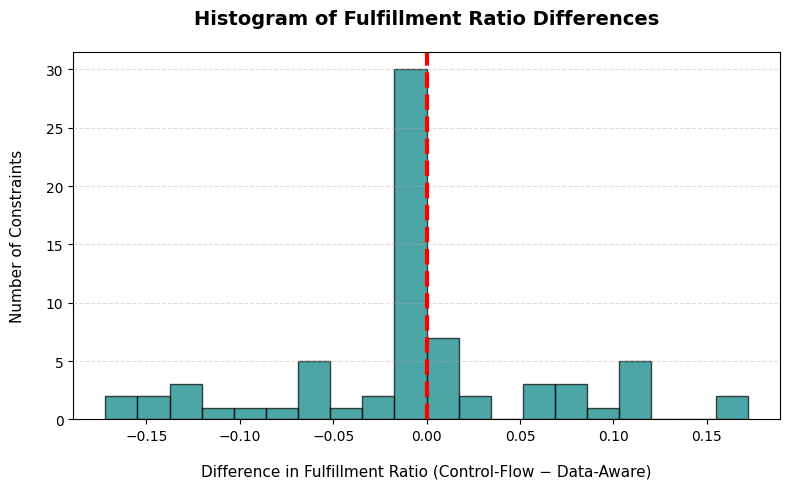

In [30]:
plot_fulfillment_diff_histogram(analyzed_df)

In [31]:
positive_df = analyzed_df[analyzed_df['diff'] > 0]

first_last = positive_df \
    .groupby('Constraint', group_keys=False) \
    .apply(lambda grp: grp.iloc[[0, -1]]) \
    .sort_values('diff', ascending=False)

first_last

/var/folders/1y/h0dyw5kj4yb01hwy9hy48wlm0000gn/T/ipykernel_61969/3691341597.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.iloc[[0, -1]]) \


,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
49,Not Response[T02 Check confirmation of receipt...,case_group == 'Group 5',405,0.481,301,0.309,0.172
49,Not Response[T02 Check confirmation of receipt...,case_group == 'Group 5',405,0.481,301,0.309,0.172
50,Not Response[T04 Determine confirmation of rec...,case_group == 'Group 5',428,0.596,301,0.432,0.164
50,Not Response[T04 Determine confirmation of rec...,case_group == 'Group 5',428,0.596,301,0.432,0.164
31,Not Alternate Response[T10 Determine necessity...,case_group != 'Group 5',447,0.756,297,0.636,0.120
31,Not Alternate Response[T10 Determine necessity...,case_group != 'Group 5',447,0.756,297,0.636,0.120
29,Not Alternate Response[T05 Print and send conf...,case_group != 'Group 5',195,0.579,152,0.461,0.118
29,Not Alternate Response[T05 Print and send conf...,case_group != 'Group 5',195,0.579,152,0.461,0.118
53,Not Response[T10 Determine necessity to stop i...,case_group != 'Group 5',449,0.757,300,0.640,0.117
53,Not Response[T10 Determine necessity to stop i...,case_group != 'Group 5',449,0.757,300,0.640,0.117


In [32]:
analyzed_df[analyzed_df['diff'] < 0].sort_values('diff')

,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
63,Responded Existence[T02 Check confirmation of ...,case_group != 'Group 5',410,0.522,304,0.694,-0.172
10,Alternate Response[T02 Check confirmation of r...,case_group != 'Group 5',407,0.514,305,0.675,-0.161
64,Responded Existence[T04 Determine confirmation...,case_group != 'Group 5',482,0.427,346,0.578,-0.151
11,Alternate Response[T04 Determine confirmation ...,case_group != 'Group 5',476,0.424,342,0.573,-0.149
67,Responded Existence[T10 Determine necessity to...,case_group == 'Group 5',441,0.245,291,0.371,-0.126
14,Alternate Response[T10 Determine necessity to ...,case_group == 'Group 5',442,0.244,292,0.370,-0.126
70,Response[T10 Determine necessity to stop indic...,case_group == 'Group 5',445,0.243,295,0.366,-0.123
66,Responded Existence[T05 Print and send confirm...,case_group != 'Group 5',190,0.411,147,0.531,-0.120
13,Alternate Response[T05 Print and send confirma...,case_group == 'Group 5',201,0.458,166,0.554,-0.096
69,Response[T05 Print and send confirmation of re...,case_group == 'Group 5',169,0.444,143,0.524,-0.080


---

_**Lossy Counting - With apriori support 0.4**_

---

In [33]:
analyzed_df, not_analyzed_df = analyze_sepsis_constraints(load_fulfillment_results_dataframe(list_result_files()[2]))

Loading file: wabo_0.4_lossy.jsonl
Total constraints discovered: 45
Constraints with higher fulfilment under No Data: 15
Constraints with higher fulfilment under Data: 26
Ties (equal fulfilment): 4

Descriptive statistics for diff (No Data - Data):
count    45.000000
mean     -0.009889
std       0.085725
min      -0.275000
25%      -0.004000
50%      -0.001000
75%       0.001000
max       0.274000
Name: diff, dtype: float64


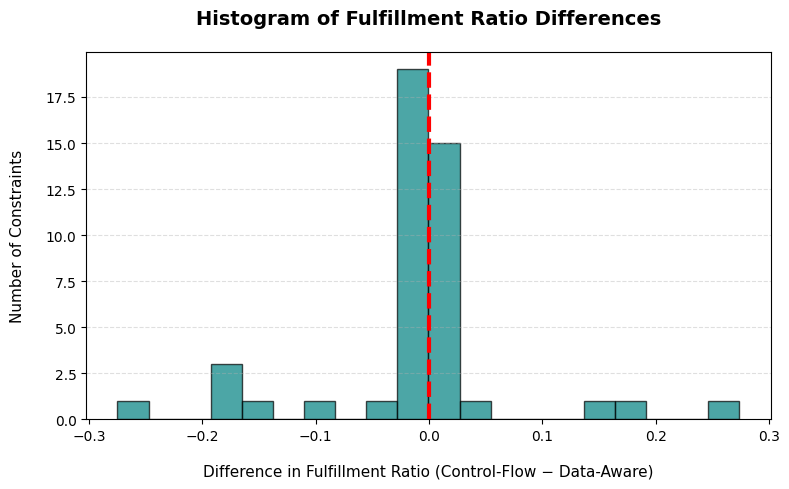

In [34]:
plot_fulfillment_diff_histogram(analyzed_df)

In [35]:
positive_df = analyzed_df[analyzed_df['diff'] > 0]

first_last = positive_df \
    .groupby('Constraint', group_keys=False) \
    .apply(lambda grp: grp.iloc[[0, -1]]) \
    .sort_values('diff', ascending=False)

first_last

/var/folders/1y/h0dyw5kj4yb01hwy9hy48wlm0000gn/T/ipykernel_61969/3691341597.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.iloc[[0, -1]]) \


,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
33,Not Responded Existence[T04 Determine confirma...,case_group == 'Group 5',267,0.554,164,0.280,0.274
33,Not Responded Existence[T04 Determine confirma...,case_group == 'Group 5',267,0.554,164,0.280,0.274
34,Not Response[T04 Determine confirmation of rec...,case_group == 'Group 5',427,0.600,294,0.425,0.175
34,Not Response[T04 Determine confirmation of rec...,case_group == 'Group 5',427,0.600,294,0.425,0.175
25,Not Chain Response[T04 Determine confirmation ...,case_group != 'Group 5',186,0.317,149,0.161,0.156
25,Not Chain Response[T04 Determine confirmation ...,case_group != 'Group 5',186,0.317,149,0.161,0.156
1,Alternate Precedence[T02 Check confirmation of...,case_group != 'Group 5',1032,0.499,782,0.471,0.028
1,Alternate Precedence[T02 Check confirmation of...,case_group != 'Group 5',1032,0.499,782,0.471,0.028
35,Not Response[T05 Print and send confirmation o...,case_group != 'Group 8',328,0.476,262,0.458,0.018
35,Not Response[T05 Print and send confirmation o...,case_group != 'Group 8',328,0.476,262,0.458,0.018


In [36]:
analyzed_df[analyzed_df['diff'] < 0].sort_values('diff')

,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
11,Alternate Response[T04 Determine confirmation ...,case_group != 'Group 5',268,0.448,166,0.723,-0.275
9,Alternate Response[T02 Check confirmation of r...,case_group != 'Group 5',442,0.527,321,0.695,-0.168
10,Alternate Response[T04 Determine confirmation ...,case_group != 'Group 5',482,0.417,333,0.583,-0.166
14,Chain Response[T04 Determine confirmation of r...,case_group == 'Group 5',181,0.674,144,0.840,-0.166
44,Responded Existence[T04 Determine confirmation...,case_group != 'Group 5',499,0.427,343,0.592,-0.165
12,Alternate Response[T05 Print and send confirma...,case_group == 'Group 8',326,0.521,264,0.610,-0.089
29,Not Precedence[T05 Print and send confirmation...,case_group != 'Group 5' and case_group != 'Gro...,352,0.477,304,0.507,-0.030
13,Chain Response[T02 Check confirmation of recei...,case_group != 'Group 5',319,0.611,306,0.631,-0.020
17,Not Alternate Precedence[T02 Check confirmatio...,case_group != 'Group 5',737,0.520,664,0.538,-0.018
4,Alternate Precedence[T05 Print and send confir...,case_group != 'Group 5',308,0.474,295,0.485,-0.011


---

_**No Lossy Counting - With apriori support 0.2**_

---

In [37]:
analyzed_df, not_analyzed_df = analyze_sepsis_constraints(load_fulfillment_results_dataframe(list_result_files()[1]))

Loading file: wabo_0.2_nl.jsonl
Total constraints discovered: 143
Constraints with higher fulfilment under No Data: 43
Constraints with higher fulfilment under Data: 93
Ties (equal fulfilment): 7

Descriptive statistics for diff (No Data - Data):
count    143.000000
mean      -0.101490
std        0.261711
min       -0.878000
25%       -0.054000
50%       -0.002000
75%        0.001500
max        0.066000
Name: diff, dtype: float64


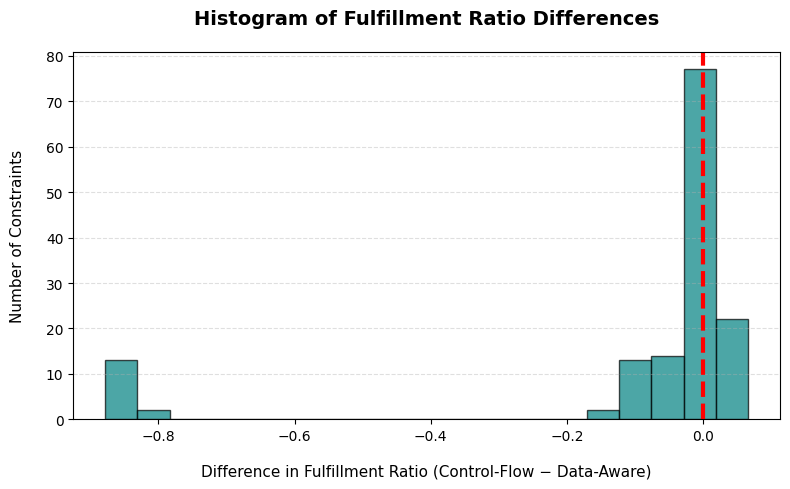

In [38]:
plot_fulfillment_diff_histogram(analyzed_df)

In [39]:
positive_df = analyzed_df[analyzed_df['diff'] > 0]

first_last = positive_df \
    .groupby('Constraint', group_keys=False) \
    .apply(lambda grp: grp.iloc[[0, -1]]) \
    .sort_values('diff', ascending=False)

first_last

/var/folders/1y/h0dyw5kj4yb01hwy9hy48wlm0000gn/T/ipykernel_61969/3691341597.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.iloc[[0, -1]]) \


,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
94,Not Response[T04 Determine confirmation of rec...,case_group != 'Group 10',505,0.564,440,0.498,6.600000e-02
94,Not Response[T04 Determine confirmation of rec...,case_group != 'Group 10',505,0.564,440,0.498,6.600000e-02
79,Not Responded Existence[T02 Check confirmation...,case_group != 'Group 10',479,0.388,442,0.335,5.300000e-02
79,Not Responded Existence[T02 Check confirmation...,case_group != 'Group 10',479,0.388,442,0.335,5.300000e-02
80,Not Responded Existence[T04 Determine confirma...,case_group != 'Group 10',507,0.582,449,0.530,5.200000e-02
...,...,...,...,...,...,...,...
60,Not Chain Response[T10 Determine necessity to ...,case_group == 'Group 10',456,0.743,450,0.742,1.000000e-03
65,Not Precedence[T04 Determine confirmation of r...,case_group != 'Group 10',584,0.539,585,0.538,1.000000e-03
108,Precedence[T06 Determine necessity of stop adv...,case_group != 'Group 10',455,0.512,456,0.511,1.000000e-03
106,Precedence[T05 Print and send confirmation of ...,case_group != 'Group 10',593,0.346,592,0.346,5.551115e-17


In [40]:
analyzed_df[analyzed_df['diff'] < 0].sort_values('diff')

,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
87,"Not Response[Confirmation of receipt, T02 Chec...",org_resource == 'admin2',631,0.122,44,1.000,-0.878
73,Not Responded Existence[Confirmation of receip...,org_resource == 'admin2',546,0.126,42,1.000,-0.874
89,"Not Response[Confirmation of receipt, T05 Prin...",org_resource == 'admin2',566,0.127,43,1.000,-0.873
41,Not Alternate Response[Confirmation of receipt...,org_resource == 'admin2',530,0.132,38,1.000,-0.868
76,Not Responded Existence[Confirmation of receip...,org_resource == 'admin2',561,0.134,43,1.000,-0.866
...,...,...,...,...,...,...,...
1,Alternate Precedence[T02 Check confirmation of...,case_group == 'Group 10',437,0.680,436,0.681,-0.001
32,Not Alternate Precedence[T02 Check confirmatio...,case_group != 'Group 10',595,0.403,594,0.404,-0.001
105,Precedence[T04 Determine confirmation of recei...,case_group == 'Group 10',458,0.485,457,0.486,-0.001
0,Alternate Precedence[T02 Check confirmation of...,case_group == 'Group 10',590,0.593,589,0.594,-0.001


---

_**No Lossy Counting - With apriori support 0.4**_

---

In [41]:
analyzed_df, not_analyzed_df = analyze_sepsis_constraints(load_fulfillment_results_dataframe(list_result_files()[3]))

Loading file: wabo_0.4_nl.jsonl
Total constraints discovered: 137
Constraints with higher fulfilment under No Data: 40
Constraints with higher fulfilment under Data: 88
Ties (equal fulfilment): 9

Descriptive statistics for diff (No Data - Data):
count    137.000000
mean      -0.106394
std        0.267717
min       -0.881000
25%       -0.055000
50%       -0.004000
75%        0.007000
max        0.069000
Name: diff, dtype: float64


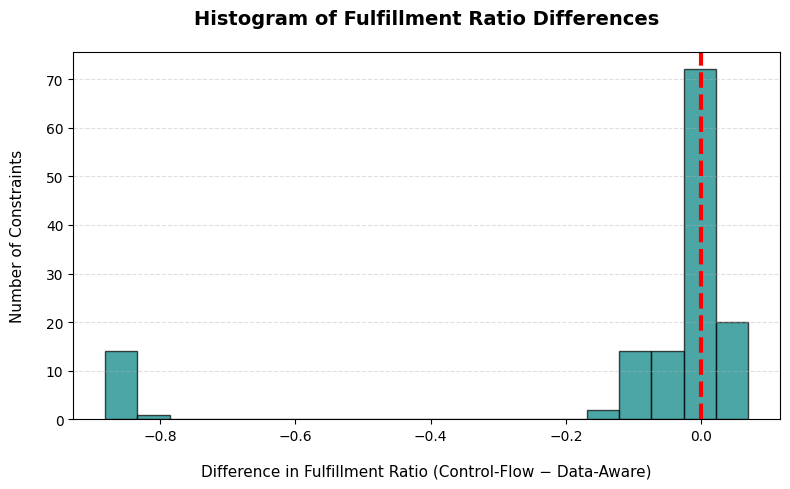

In [42]:
plot_fulfillment_diff_histogram(analyzed_df)

In [43]:
positive_df = analyzed_df[analyzed_df['diff'] > 0]

first_last = positive_df \
    .groupby('Constraint', group_keys=False) \
    .apply(lambda grp: grp.iloc[[0, -1]]) \
    .sort_values('diff', ascending=False)

first_last

/var/folders/1y/h0dyw5kj4yb01hwy9hy48wlm0000gn/T/ipykernel_61969/3691341597.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.iloc[[0, -1]]) \


,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
40,Not Alternate Response[T02 Check confirmation ...,case_group == 'Group 5',501,0.409,447,0.340,6.900000e-02
40,Not Alternate Response[T02 Check confirmation ...,case_group == 'Group 5',501,0.409,447,0.340,6.900000e-02
86,Not Response[T04 Determine confirmation of rec...,case_group == 'Group 5',483,0.580,429,0.522,5.800000e-02
86,Not Response[T04 Determine confirmation of rec...,case_group == 'Group 5',483,0.580,429,0.522,5.800000e-02
85,Not Response[T02 Check confirmation of receipt...,case_group == 'Group 5',470,0.385,430,0.330,5.500000e-02
...,...,...,...,...,...,...,...
30,Not Alternate Precedence[T05 Print and send co...,case_group == 'Group 5',453,0.567,453,0.565,2.000000e-03
53,Not Chain Response[T10 Determine necessity to ...,case_group != 'Group 5',454,0.769,446,0.767,2.000000e-03
53,Not Chain Response[T10 Determine necessity to ...,case_group != 'Group 5',454,0.769,446,0.767,2.000000e-03
56,Not Precedence[T02 Check confirmation of recei...,case_group == 'Group 5',467,0.285,466,0.285,5.551115e-17


In [44]:
analyzed_df[analyzed_df['diff'] < 0].sort_values('diff')

,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
64,Not Responded Existence[Confirmation of receip...,org_resource == 'admin2',529,0.119,38,1.000,-0.881
79,"Not Response[Confirmation of receipt, T02 Chec...",org_resource == 'admin2',561,0.121,42,1.000,-0.879
34,Not Alternate Response[Confirmation of receipt...,org_resource == 'admin2',701,0.126,51,1.000,-0.874
37,Not Alternate Response[Confirmation of receipt...,org_resource == 'admin2',672,0.129,48,1.000,-0.871
66,Not Responded Existence[Confirmation of receip...,org_resource == 'admin2',678,0.134,52,1.000,-0.866
...,...,...,...,...,...,...,...
61,Not Precedence[T06 Determine necessity of stop...,case_group != 'Group 5',573,0.705,572,0.706,-0.001
63,Not Precedence[T10 Determine necessity to stop...,case_group == 'Group 5',482,0.483,481,0.484,-0.001
96,"Precedence[T02 Check confirmation of receipt, ...",case_group != 'Group 5',585,0.667,585,0.668,-0.001
100,Precedence[T05 Print and send confirmation of ...,case_group == 'Group 5',585,0.388,584,0.389,-0.001


---

_**No Lossy Counting - With apriori support 0.6**_

---

In [45]:
analyzed_df, not_analyzed_df = analyze_sepsis_constraints(load_fulfillment_results_dataframe(list_result_files()[4]))

Loading file: wabo_0.6_nl.jsonl
Total constraints discovered: 92
Constraints with higher fulfilment under No Data: 16
Constraints with higher fulfilment under Data: 69
Ties (equal fulfilment): 7

Descriptive statistics for diff (No Data - Data):
count    92.000000
mean     -0.158902
std       0.300188
min      -0.869000
25%      -0.109000
50%      -0.004000
75%      -0.000750
max       0.074000
Name: diff, dtype: float64


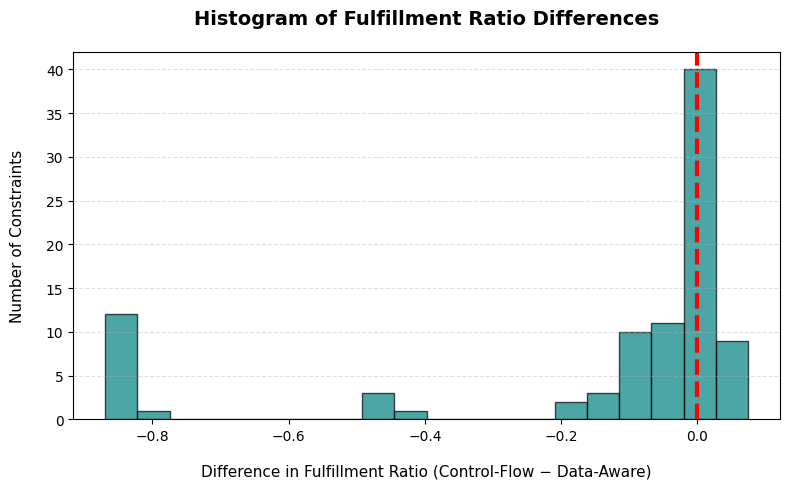

In [46]:
plot_fulfillment_diff_histogram(analyzed_df)

In [47]:
positive_df = analyzed_df[analyzed_df['diff'] > 0]

first_last = positive_df \
    .groupby('Constraint', group_keys=False) \
    .apply(lambda grp: grp.iloc[[0, -1]]) \
    .sort_values('diff', ascending=False)

first_last

/var/folders/1y/h0dyw5kj4yb01hwy9hy48wlm0000gn/T/ipykernel_61969/3691341597.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.iloc[[0, -1]]) \


,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
63,Not Response[T04 Determine confirmation of rec...,case_group == 'Group 5',332,0.536,288,0.462,0.074
63,Not Response[T04 Determine confirmation of rec...,case_group == 'Group 5',332,0.536,288,0.462,0.074
53,Not Responded Existence[T04 Determine confirma...,case_group == 'Group 5',337,0.585,295,0.525,0.060
53,Not Responded Existence[T04 Determine confirma...,case_group == 'Group 5',337,0.585,295,0.525,0.060
54,Not Responded Existence[T04 Determine confirma...,case_group == 'Group 5',333,0.514,299,0.455,0.059
54,Not Responded Existence[T04 Determine confirma...,case_group == 'Group 5',333,0.514,299,0.455,0.059
52,Not Responded Existence[T02 Check confirmation...,case_group == 'Group 5',471,0.291,440,0.239,0.052
52,Not Responded Existence[T02 Check confirmation...,case_group == 'Group 5',471,0.291,440,0.239,0.052
31,Not Alternate Response[T02 Check confirmation ...,case_group == 'Group 5',479,0.376,442,0.324,0.052
31,Not Alternate Response[T02 Check confirmation ...,case_group == 'Group 5',479,0.376,442,0.324,0.052


In [48]:
analyzed_df[analyzed_df['diff'] < 0].sort_values('diff')

,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
28,Not Alternate Response[Confirmation of receipt...,org_resource == 'admin2',525,0.131,38,1.000,-0.869
48,Not Responded Existence[Confirmation of receip...,org_resource == 'admin2',519,0.131,38,1.000,-0.869
49,Not Responded Existence[Confirmation of receip...,org_resource == 'admin2',545,0.132,46,1.000,-0.868
57,"Not Response[Confirmation of receipt, T04 Dete...",org_resource == 'admin2',517,0.132,38,1.000,-0.868
56,"Not Response[Confirmation of receipt, T02 Chec...",org_resource == 'admin2',528,0.138,39,1.000,-0.862
...,...,...,...,...,...,...,...
8,Alternate Precedence[T10 Determine necessity t...,case_group == 'Group 5',286,0.448,285,0.449,-0.001
24,Not Alternate Precedence[T06 Determine necessi...,case_group != 'Group 5',293,0.509,292,0.510,-0.001
36,Not Chain Response[T04 Determine confirmation ...,case_group == 'Group 5',312,0.926,302,0.927,-0.001
40,Not Precedence[T04 Determine confirmation of r...,case_group == 'Group 5',446,0.455,445,0.456,-0.001
